### Assignment 3: Spectral Analysis on EEG data

Typical sleep in human adults includes the well-known REM sleep as well as four well-characterized stages of non-REM sleep, or NREM sleep. During wakefulness, alpha waves dominate the EEG, in the frequency range 8 to 13 Hz. As the subject enters the first stage of non-REM sleep, the dominant wave type transitions from alpha waves to theta waves, in the range 4 to 7 Hz. This is the first stage of non-REM sleep.

The second and third stages of non-REM sleep are characterized by sleep spindles, at 12 to 16 Hz, and the appearance of delta waves, ranging in frequency from 0.5 to 4 Hz. The fourth stage of sleep is characterized by a majority of power distribution in the delta wave band. 

The third and fourth stages of NREM sleep are also termed slow-wave sleep, to denote the prevalence of the low frequency delta waves in these two stages.

Here, you will analyze EEG data from a non-medicated human recorded continuously in the course of 24 hours. The details for this data (and additional datasets) can be found [here](https://www.physionet.org/content/sleep-edf/1.0.0/). 

The original EEG data is in a standard format for data sharing named “European Data Format” or EDF (files *sc4002e0.hyp* and *sc4002e0.rec*) and has been read and packaged in MATLAB using the code **edfread.m** that you can find in the **I:\\31869** folder. We can now read this packaged MATLAB file (*eeg.mat*) using the command **loadmat** from the module *scipy.io* in Python.

#### Import the libraries that we need

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat # if we only need one function from one module, instead of importing the full
                                #module we can use this to import just that function

Read the data. As it comes in a dictionary, we assign the data of interest to specific variables to simplify our code:

In [2]:
data = loadmat("C:\\Users\\bnola\\Documents\\Data Analysis\\eeg.mat")
hd,hdh=data['hd'],data['hdh']
rec,rech=data['rec'],data['rech'][0]

This will give you information on the recording in the structures **hd**, **hdh**, and the actual data in the matrices **rec** and **rech**.

The two data files include two different data: *sc4002e0.rec* (**hd**, **rec**) has the physiological recordings in 7 different rows: electrooculogram (EOG), two different EEG channels sampled at 100 Hz, submental-EMG, oro-nasal airflow, rectal body temperature and an event marker. We will look only at one EEG channel, in the second row of the matrix **rec**. In the file *sc4002e0.hyp* (**hdh**, **rech**) we have the hypnograms, which is the score of the sleep stage as manually identified by an expert from the EEG data. 
The sleep stage is scored every 30 seconds in the vector **rech** and it encodes the sleep stage as:

Wakefulness: 0,
Stage 1 non-REM: 1
Stage 2 non-REM: 2
Stage 3 non-REM: 3
Stage 4 non-REM: 4
REM: 5
Awakening: 6 
unscored: 9

#### 1) Let's first look at one EEG channel, in the second row of the matrix **rec**. Plot this data (EEG recording during 24 hours) against time, considering that the sample frequency is fs=100 Hz. 


First, let's just define the sampling frequencies of our two time series, **rec** and **rech**, which we name **fs** and **fs_hyp**, respectively. Also, we will define the variable **eeg** containing the EEG data that we will specifically look at (second row in **rec**).

In [3]:
fs = 100 #sampling frequency of voltage EEG, in Hz = 1/s
fs_hyp = 1./30. #sampling frequency of histogram, in Hz = 1/s
eeg = rec[1] #EEG data to look at 

Now, you will need to build a vector of times **tm** that has the same length as **eeg** and increases in steps of 1/**fs** seconds. Similarly, you will also need a vector of times **tmh** that marks the times of acquisition of each element in **rech**. There are many ways of doing this. Find yours!

In [4]:
tm = np.arange(eeg.size) / fs
tmh = np.arange(rech.size) / fs_hyp

Now plot the two signals (**eeg** and **rech**) in the same figure using the command **subplot** to generate one graph on top of the other (this means, graphs in 2 rows and 1 column, see the help for the command subplot with **help(subplot)**). Make sure you use the same units for the time axis in both plots (either seconds or hours) and then enforce the same x-axis limits using the command **xlim**. Can you see the traces of sleep stages in the raw EEG data? Zoom in to focus on specific stages by manipulating the limits in **xlim**.

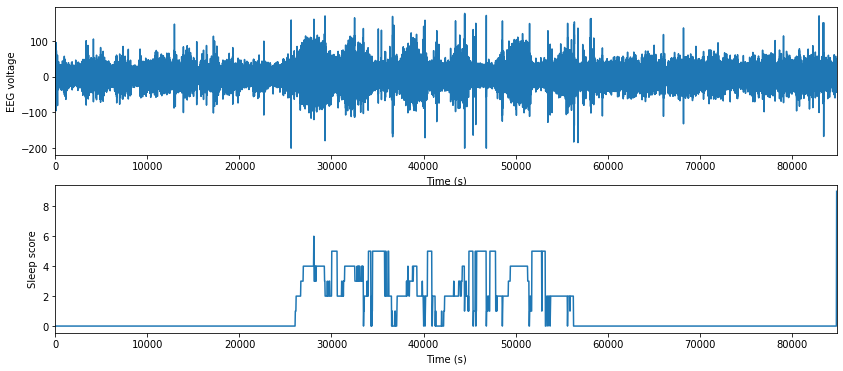

In [5]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14,6))
ax1.plot(tm, eeg)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('EEG voltage')
ax1.set_xlim([tm.min(), tm.max()])
ax2.plot(tmh, rech)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Sleep score')
ax2.set_xlim([tmh.min(), tmh.max()]);

#### 2) You will now quantify this in terms of the oscillatory frequencies that contribute in the different stages. You will apply spectral analysis techniques.

First use *periodogram* to obtain the power spectrum of the signal in **eeg**. You will need to import this function from the Python module scipy.signal. Plot it both in a linear axis with *plt.plot* and in a logarithmic axis with *plt.semilogy*, in two separate plots with *subplot*. Use **xlim** to look only at EEG relevant frequencies up to 40 Hz (beyond those frequencies the skull filters out all brain-derived signals).

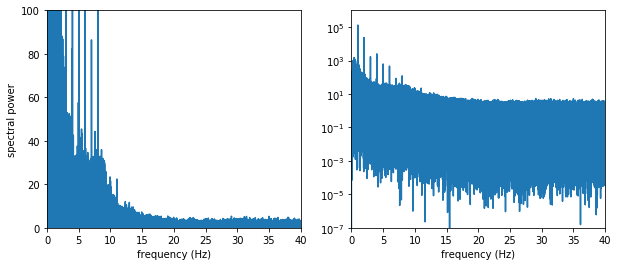

In [6]:
from scipy.signal import periodogram

f,p=periodogram(eeg,fs)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(f, p)
ax1.set_xlim([0,40])
ax1.set_ylim([0,100])
ax1.set_xlabel('frequency (Hz)')
ax1.set_ylabel('spectral power')
ax2.semilogy(f, p)
ax2.set_xlim([0,40])
ax2.set_ylim([10e-8,10e5])
ax2.set_xlabel('frequency (Hz)');
# now we plot it, both linear with plt.plot and in logarithmic scale with plt.semilogy


You will see some sharp peaks at 1 Hz, 2Hz, 3 Hz, 4 Hz, 5Hz and 6 Hz. These are artifacts of the recording equipment. You can readily identify these artifacts because they are singular, sharp events that cannot have a biological origin. 

Now use **ylim** in the code of the cell above to show clearly the variance of your estimate for all frequencies in the two graphs. What do you see? For which of the two graphs are you better able to get a view of the variance of your power spectrum estimate at all frequencies?

In [7]:
len(eeg)

8490000



Notice the very noisy aspect of this evaluation, we can barely see anything apart from the sharp artifacts at singular frequencies! In order to reduce the variance of the power spectrum estimate, we can split our data in smaller pieces (for instance 30 min) and then average together the resulting spectra. This is something that the command **welch** (from Python module *scipy.signal*) accomplishes automatically for you. 

Use the command **welch** to compute the power spectrum using the Welch method. The most important arguments for this command are the sampling frequency (*fs*) and the length of each segment on which we want to compute de power spectrum and then average (*nperseg*, indicated in number of data points in each segment). 

Plot this in two graphs for different values of *nperseg*, one corresponding to 30 minutes, and one to 30 seconds.



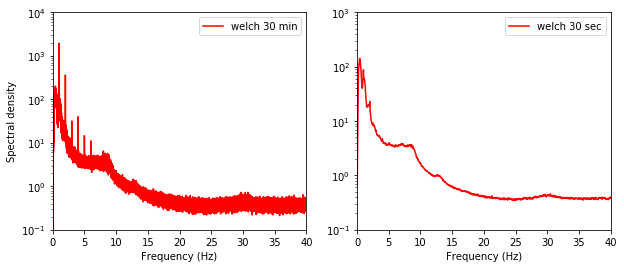

In [5]:
from scipy.signal import welch

f1,p1=welch(eeg, nperseg=30*60*fs, fs=100)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.semilogy(f1, p1, color='r', lw=1.5, label='welch 30 min')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Spectral density')
ax1.set_xlim([0,40])
ax1.set_ylim([10e-2,10e3])
ax1.legend(loc=1)

f,p=welch(eeg, nperseg=30*fs, fs=100)
ax2.semilogy(f, p, color='r', lw=1.5, label='welch 30 sec')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_xlim([0,40])
ax2.set_ylim([10e-2,10e2])
ax2.legend(loc=1);


You can now see the effect of reducing *nperseg*, and thus increasing the number of segments that are averaged to obtain the estimate: the variance is reduced (great!) but the spectral features (peaks) are smoothed (not so good, if interested in fine details of the spectrum). This is the compromise to consider. Luckily for us, biological rhythms are very noisy (so we need a lot of averaging), but they are generally characterized by broad power peaks, such as what you see at 0.4, 0.8, 1.8, 8 or 13 Hz, so we do not care so much about frequency resolution and can usually do with short *nperseg* windows. 

#### 3) There is a problem in interpreting the power spectrum obtained in point 2) above: spectral quantities are well defined for stationary signals and our recording has clearly two distinct phases as you see in the graph of point 1 above, the waking and the sleeping phases. 

You can deal with this by separating in your data **eeg** all the data points that correspond to the waking (0) phase from the ones that correspond to sleep (not 0). Use for this the hypnogram in **rech**: the time points in which rech is zero correspond to waking and the rest correspond to sleep. You can thus obtain the times of the transitions from waking to sleep and from sleep to waking and use that to cut the data in **eeg** into two separate datasets on which to now compute the power spectrum using **welch** as done in point 2 above.

Hint 1: Identify the indices of **rech** that contain times before and after the transitions. 

Hint 2: Be careful with outliers. Use a graphical tool to visualize the indexes you found and ignore the outlier(s). To get the index number and not a boolean, use **np.where** 




[869 870 871 872 873 874 875 876 877 878]
[1868 1869 1870 1871 1872 1873 1874 1875 1876 2830]


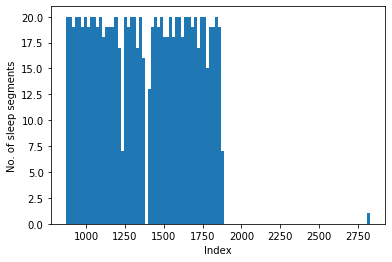

In [6]:
# find the index where rech was not 0 (code for asleep)
asleep_indx, = np.where(rech!=0)

# inspect the resulting indices graphically to identify those that make sense for our splitting
plt.hist(asleep_indx, bins=100)
plt.xlabel('Index')
plt.ylabel('No. of sleep segments')

# We can see there is an outlier at the end, so let's inpect the indexes
asleep_indx = np.array(asleep_indx)
print(asleep_indx[:10])
print(asleep_indx[-10:])

# These two indices seem to be good estimates for the transitions awake->asleep and asleep->awake, respectively
beg = asleep_indx[0]
end = asleep_indx[-2]

The hypnogram signal is sampled every 30 seconds, while the EEG is sampled 100 times on each second. Now you found the index of the beginning of the sleeping phase and another index for its end, but these are indices for **rech**. You now need to convert them to indices for **eeg** (an index on the hypnogram does not index the same time point on the EEG signal, because of the difference in sampling frequency). You need to take into consideration this difference in sampling rate. A good approach is to think how to relate these two sampling rates. 

Once you get the right indices, split the **eeg** data for asleep and awake, and plot the two spectra on the same graph: use *semilogy* and use the argument color to choose proper colors.

What are the main features that distinguish the two phases, waking and sleep, spectrally?

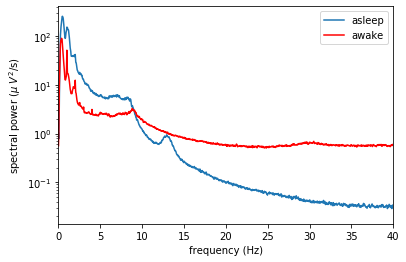

In [153]:
# obtain the corresponding indices for the eeg signal, considering the change in sampling frequency
t_beg=int(beg*fs/fs_hyp)
t_end=int(end*fs/fs_hyp)

# cut the eeg data in the two pieces, asleep and awake, the awake piece concatenates the before and after sleep waking periods
eeg_asleep = eeg[t_beg:t_end]
eeg_awake = np.concatenate((eeg[:t_beg],eeg[t_end:]))

# now compute the power spectra for each subset using the Welch method
s_f,s_p = welch(eeg_asleep,nperseg=30*fs,fs=fs)
a_f,a_p = welch(eeg_awake,nperseg=30*fs,fs=fs)

# plot the power spectra on the same axis, different colors, use "label" to then get the legend()
plt.semilogy(s_f, s_p, label='asleep')
plt.semilogy(a_f, a_p, 'r', label='awake')
plt.xlabel('frequency (Hz)')
plt.ylabel('spectral power ($\mu$ $V^2$/s)')
plt.legend()
plt.xlim(0,40);

#### 4) The way in which we dealt with non-stationarity in point 3 above was not optimal, because we know that sleep itself is subdivided in phases, so the sleep stage itself cannot be looked at as a stationary signal either. 

We deal with that by computing power spectra on small windows of data as we slide through the whole dataset. This is what we call a spectrogram. You can directly obtain it with the command *specgram* in the matplotlib module. Again use the window size of 30 sec as the argument *NFFT* of this function (equivalent to *nperseg* in *welch*). Interpret this graph. How do you identify the sleep period from the frequency content in this graph?


In [122]:
x = eeg[...,None]
y = x[:,0]

2956

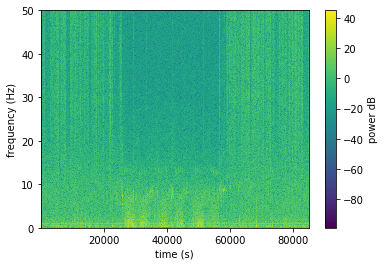

In [166]:
Pxx1, freqs, bins, im = plt.specgram(y, NFFT=30*fs, Fs=fs)
plt.xlabel('time (s)')
plt.ylabel('frequency (Hz)')
cbar = plt.colorbar()
cbar.set_label('power dB')


##### 5) You can now use the hypnogram in rech to separate the eeg data points that come from periods identified as NREM1-2, NREM 3-4 and REM, and see in detail the spectral properties that characterize these sleep phases.

You should first separate the pieces of **eeg** data corresponding to each of these sleep phases. You can get inspiration from 3) above, but this now requires a more automated procedure. Here below is a possible backbone for this, but you can of course find some other possible approach.


In [140]:
# we first prepare 3 empty arrays to store the data of the 3 sleep phases of interest (NREM1-2, NREM3-4, REM)
eeg12=[]
eeg34=[]
eeg5=[]

# we now cycle through rech and based on the hypnogram value, append the corresponding piece of eeg data to the right array
for i in range(0, len(rech)):
    if rech[i]==1 or rech[i]==2:
        t_beg_i=int(i*fs/fs_hyp)
        t_end_i=int((i+1)*fs/fs_hyp)
        eeg12.append(eeg[t_beg_i:t_end_i])
    
    elif rech[i]==3 or rech[i]==4:
        t_beg_i=int(i*fs/fs_hyp)
        t_end_i=int((i+1)*fs/fs_hyp)
        eeg34.append(eeg[t_beg_i:t_end_i])
    
    elif rech[i]==5:
        t_beg_i=int(i*fs/fs_hyp)
        t_end_i=int((i+1)*fs/fs_hyp)
        eeg5.append(eeg[t_beg_i:t_end_i])

# we finally concatenate all the pieces within each array
eeg12=np.concatenate(eeg12)
eeg34=np.concatenate(eeg34)
eeg5=np.concatenate(eeg5)



Now you can plot the power spectra of these different periods using *welch*. Can you see the hallmarks of the various rhythms described in the introduction to this assignment?

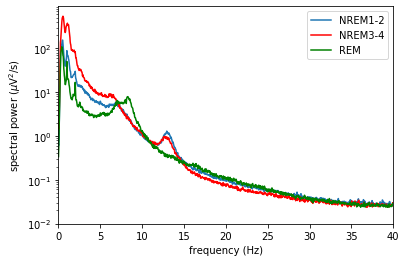

In [142]:
# we now compute the power spectrum for each subset of data
f_12, p_12 = welch(eeg12,nperseg=30*fs,fs=fs)
f_34, p_34 = welch(eeg34,nperseg=30*fs,fs=fs)
f_5, p_5 = welch(eeg5,nperseg=30*fs,fs=fs)


# and we plot it on the same axes, using labels for the legend, and showing only frequencies up to 40 Hz
plt.semilogy(f_12, p_12, label='NREM1-2')
plt.semilogy(f_34, p_34, 'r', label='NREM3-4')
plt.semilogy(f_5, p_5, 'g',label='REM')
plt.legend()
plt.xlim(0,40)
plt.xlabel('frequency (Hz)')
plt.ylabel('spectral power ($\mu$V$^2$/s)');

OPTIONAL: Alternatively, you could obtain and plot the same 3 spectra by using the power matrix returned by *specgram* above. Can you do that?